In [1]:
from __future__ import annotations

import datetime
import math
import xml.etree.ElementTree as ET
from common import load_csv, Route, Checkpoint, solar_power_out
from sklearn.linear_model import LinearRegression
import numpy as np
import time

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#constants
CELL_AREA = 0.0153 #m^2

In [3]:
#absolute cell tilts 
tilts = {
    "hood_front": {
        "left_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "left_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_center_3x4": [33.38, 33.38, 33.38, 27.64, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44],
        "right_stairs": [33.38, 27.64, 27.64, 27.63, 27.63, 27.63, 27.44, 27.44, 27.44]
    },
    "top_front": {
        "leftmost_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftmost_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftmost_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "leftcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "leftcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "leftcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightcenter_top_3x2": [28.52, 28.52, 28.52, 22.16, 22.16, 22.16],
        "rightcenter_center_3x2": [22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightcenter_bottom_3x2": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14],
        "rightmost_top_4x3": [28.52, 28.52, 28.52, 28.52, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16, 22.16],
        "rightmost_bottom_4x3": [22.16, 22.16, 22.16, 22.16, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14]
    },
    "top_back": {
        "leftmost_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "leftcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightcenter_3x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64],
        "rightmost_4x4": [13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 13.14, 1.11, 1.11, 1.11, 1.11, -3.64, -3.64, -3.64, -3.64]
    },
    "back": {
        "leftmost_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightcenter_top_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_top_4x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftmost_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "leftcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64], 
        "rightcenter_bottom_3x4": [-3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64, -3.64],
        "rightmost_bottom-4x4": [-4, -4, -4, -4, -5, -5, -5, -5, -6, -6, -6, -6]
    }
}

In [4]:
from astral import LocationInfo
from astral.sun import azimuth,elevation
class CellSolarData:
    def __init__(self, coord: Checkpoint, time: datetime.datetime, tilt: float):
        l = LocationInfo()
        l.name = f'{coord.lat},{coord.lon}'
        l.region = 'United States'
        l.timezone = 'US/Central' #update to be dynamic
        l.latitude = coord.lat
        l.longitude = coord.lon
        self.heading_azimuth_angle = coord.azimuth
        self.heading_azimuth_angle = 180 + self.heading_azimuth_angle if tilt < 0 else self.heading_azimuth_angle
        self.heading_azimuth_angle %= 360
        self.tilt = tilt * -1 if tilt < 0 else tilt
        self.lat = coord.lat
        self.lon = coord.lon
        self.elevation = coord.elevation / 1000 #convert to km
        self.time = time
        self.sun_elevation_angle = elevation(l.observer, time)
        self.sun_elevation_angle = max(0, self.sun_elevation_angle)
        self.sun_azimuth_angle = azimuth(l.observer, time)
        self.air_mass = 1/(math.cos(math.radians(90-self.sun_elevation_angle)) + 0.50572*(96.07995-(90-self.sun_elevation_angle))**-1.6364)
        self.incident_diffuse = 1.1*1.353*((1-0.14*(self.elevation / 1000))*0.7**self.air_mass**0.678 + 0.14*(self.elevation / 1000)) 
        self.cell_diffuse = self.incident_diffuse*(math.cos(math.radians(self.sun_elevation_angle))*math.sin(math.radians(self.tilt))*math.cos(math.radians(self.heading_azimuth_angle - self.sun_azimuth_angle)) + math.sin(math.radians(self.sun_elevation_angle))*math.cos(math.radians(self.tilt)))
        self.cell_irradiance = self.cell_diffuse * 1000 #convert to watts/m^2
        self.cloud_cover = coord.cloud_cover / 100
        cell_power_out = solar_power_out(self.cell_irradiance, self.cloud_cover) * CELL_AREA #watts
        if isinstance(self.incident_diffuse, complex):
            print(self.air_mass, self.incident_diffuse, self.sun_elevation_angle, self.tilt, self.heading_azimuth_angle, self.sun_azimuth_angle, time)
        self.cell_power_out = cell_power_out if cell_power_out > 0 else 0
    

In [5]:
def section_solar_power_out(coord: Checkpoint, time: datetime.datetime, section_tilts: dict):
    section_irradiance_sum = 0
    tilt_irradiances: dict[float, CellSolarData] = {}
    for array in section_tilts.keys():
        array_sum = 0
        for cell_angle in section_tilts[array]:
            if(cell_angle in tilt_irradiances):
                array_sum += tilt_irradiances[cell_angle].cell_power_out
            else:
                cell = CellSolarData(coord, time, cell_angle)
                
                # if(cell_angle<0):
                #     print(cell_angle)
                #     print(coord.azimuth)
                #     print(cell.__dict__)
                tilt_irradiances[cell_angle] = cell
                array_sum += cell.cell_power_out
        section_irradiance_sum += array_sum
    #watts
    return section_irradiance_sum

def total_solar_power_out(coord: Checkpoint, time: datetime.datetime, tilts: dict):
    # iterating over all of the sections in the car
    car_power_sum: float = 0
    for section in tilts.keys():
        car_power_sum += section_solar_power_out(coord, time, tilts[section])
    #watts
    return car_power_sum

    #sum of all the modules on the car
from pytz import timezone
cen = timezone("US/Central")
est = timezone("US/Eastern")
utc = timezone("UTC")

def energy_captured_along_route_vconst(time_initial: datetime.datetime, velocity: float, route: Route):
    current_time = time_initial
    total_energy = 0
    velocity_ms = velocity / 3.6 #convert to m/2
    power_list = []
    for i in range(len(route.checkpoints)-1):
        segment_distance = route.checkpoints[i+1].distance if i==0 else route.checkpoints[i+1].distance - route.checkpoints[i].distance

        segment_time = segment_distance/velocity_ms

        total_power_in_current = total_solar_power_out(route.checkpoints[i], current_time, tilts=tilts)
        current_time += datetime.timedelta(seconds=segment_time)
        total_power_in_next = total_solar_power_out(route.checkpoints[i+1], current_time, tilts=tilts)
        total_power_in_avg = (total_power_in_current + total_power_in_next) / 2
        power_list.append(total_power_in_avg)
        total_energy += total_power_in_avg*segment_time #watt seconds
   
    print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return (total_energy/3600, power_list) #in watt hours

def energy_captured_between_points(c1: Checkpoint, current_time: datetime.datetime, segment_time: int):
    total_power_in_curr = total_solar_power_out(c1, current_time, tilts=tilts)
    energy_this_segment = total_power_in_curr * segment_time / 3600 #wh
    return energy_this_segment

def energy_captured_along_route(time_initial: datetime.datetime, velocities: list[float], route: Route):
    current_time = time_initial
    total_energy = 0
    
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2

        segment_distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance

        segment_time = segment_distance / v_avg_ms
        energy_this_segment = energy_captured_between_points(route.checkpoints[i-1], current_time, segment_time)
        current_time += datetime.timedelta(seconds=segment_time)
        power_per_checkpoint.append(energy_this_segment * 3600 / segment_time) 
        total_energy += energy_this_segment #watt hours
   
    # print("times: ", time_initial.astimezone(est), current_time.astimezone(est), (current_time - time_initial).seconds / 60)
    # print("avg power: ", total_energy / (current_time - time_initial).seconds)
    return total_energy, power_per_checkpoint #in watt hours, watts


In [6]:
#for independence to topeka, 2022
speed_limits = { #distance and speed in mph
    0: 20, #distance: speed limit
    1: 30,
    1.6: 35,
    7.1: 30,
    7.6: 25,
    7.9: 30,
    8.7: 40,
    16.7: 35,
    18.5: 45,
    20.1: 40,
    24.2: 35,
    24.5: 45,
    34.5: 50,
    38.5: 30,
    38.7: 50,
    43.3: 40,
    44.3: 30,
    44.6: 35,
    45.6: 40,
    46: 45,
    55.7: 55,
    60.4: 45,
    61.6: 55,
    69.6: 45,
    70.2: 60,
    76.6: 55,
    86.5: 45,
    87: 55,
    93.9: 45,
    94.9: 40,
    96: 30,
    97: 40,
    98: 30,
    98.25: 25
}

In [7]:
air_density = 1.204 #kg/m^3
coef_drag = 0.19
coef_rr = 0.0023
car_mass = 575 #kg
accel_g = 9.81 #m/s^2
wheel_radius = 0.2 #m
wind_speed = 0 #km/h
cross_section = 2.21 #m^2


def calculate_work(grad: float, speed_initial: float, speed_end: float, time: float):
    # _speed_0 = 0.277777778*speed_initial #m/s
    # _speed_1 = 0.277777778*speed_end #m/s
    _speed_0 = speed_initial
    _speed_1 = speed_end
    accel = (_speed_1 - _speed_0) / time
    force_rr = coef_rr*car_mass*accel_g*math.cos(grad)
    force_drag = 0.5*air_density*coef_drag*((_speed_0 + _speed_1)/2 + wind_speed)**2
    force_grad = car_mass*accel_g*math.sin(grad)
    force_accel = car_mass*accel
    accel_distance = time*_speed_0 + (accel*time**2)/2
    force_tractive = force_rr + force_drag + force_grad + force_accel
    work = accel_distance * force_tractive 

    return work #J

In [8]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
def predict_average_electrical_power(avg_tractive_power: float):
    efficiencyDataX = np.array([0, 16.688, 152.532, 246.05, 335.306, 423.94, 513.536, 677.019,
    840.528, 996.03, 1147.608, 1278.624, 1405.316, 1537.61, 1783.478, 1974.78])
    efficiencyDataY = np.array([0, 28, 171, 266, 359, 451, 544, 721, 898, 1071, 1242, 1402, 1558, 1718, 2069, 2385])
    
    degree = 3
    polyreg = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    polyreg.fit(efficiencyDataX.reshape(-1,1), efficiencyDataY)
    # import matplotlib.pyplot as plt
    # X_seq = np.linspace(min(efficiencyDataX), max(efficiencyDataX), 300).reshape(-1, 1)
    # plt.figure()
    # plt.scatter(efficiencyDataX,efficiencyDataY)
    # plt.plot(X_seq,polyreg.predict(X_seq),color="black")
    # plt.title("Polynomial regression with degree "+str(degree))
    # plt.show()
    avg_electrical_power = polyreg.predict(np.array([avg_tractive_power]).reshape((-1,1)))
    return avg_electrical_power[0] #Watts

predict_average_electrical_power(0)

3.301983887797178

In [9]:
def solve_for_gradient(delta_elev, delta_d):
    c = math.sqrt(delta_d**2 + delta_elev**2)
    return math.asin(delta_elev/c)

In [10]:
def energy_used_between_points(c1: Checkpoint, c2: Checkpoint, speed_initial: float, speed_end: float, time: float):
    theta = solve_for_gradient(c2.elevation - c1.elevation, c2.distance - c1.distance)
    work = calculate_work(theta, speed_initial, speed_end, time)
    avg_tractive_power = work / time
    if avg_tractive_power <= 0:
        regen_efficiency = 0.05
        avg_electrical_power = avg_tractive_power * regen_efficiency
    else:
        avg_electrical_power = predict_average_electrical_power(avg_tractive_power)
    
    electrical_energy = avg_electrical_power * time
    passive_consumption = 10 #W
    electrical_energy += passive_consumption * time
    # print(f'theta: {math.degrees(theta)}, tractive: {avg_tractive_power}, elec: {avg_electrical_power}')
    return electrical_energy, avg_electrical_power, avg_tractive_power

def energy_used_along_route(route: Route, velocities: list[float]):
    total_energy = 0
    power_per_checkpoint = [0]
    for i in range(1, len(route.checkpoints)):
        old_speed = velocities[i-1] / 3.6
        new_speed = velocities[i] / 3.6
        v_avg_ms = (old_speed + new_speed) / 2
        time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / v_avg_ms
        energy_used, avg_electrical_power, _ = energy_used_between_points(route.checkpoints[i-1], route.checkpoints[i], old_speed, new_speed, time)
        power_per_checkpoint.append(avg_electrical_power)
        total_energy += energy_used
        # print(energy_used/3600)
    total_energy /= 3600
    return total_energy, power_per_checkpoint #wH


In [11]:
def solve_for_time(current_velocity: float, accel: float, distance: float):
    assert current_velocity**2 + 2*accel*distance < 0
    time = (-current_velocity + math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel #s
    if time < 0:
        time = (-current_velocity - math.sqrt(current_velocity**2 + 2*accel*distance) )/ accel 
    return time
def average_velocity(route: Route, velocities: list[float]):
    times = []
    total_time = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            avg_v = (velocities[i] + velocities[i-1])/2
            time = (route.checkpoints[i].distance - route.checkpoints[i-1].distance) / avg_v
            times.append(time)
            total_time += time
    v_avg = 0
    for i in range(len(route.checkpoints)-1):
        if i > 0:
            v_avg += velocities[i-1] * times[i-1] / total_time
    return v_avg


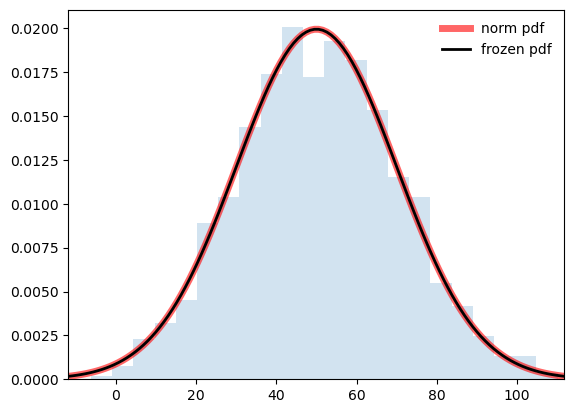

110.07952949088573 -6.199618656159572


In [65]:

from scipy.stats import genhalflogistic, norm
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1)
a = 0.77
mean, var, skew, kurt = genhalflogistic.stats(a, moments='mvsk')
loc = 50
scale = 20
x = np.linspace(norm.ppf(0.001, loc=loc, scale=scale), norm.ppf(0.999, loc=loc, scale=scale), 120)
ax.plot(x, norm.pdf(x, loc=loc, scale=scale), 'r-', lw=5, alpha=0.6, label='norm pdf')
rv = norm(loc=loc, scale=scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='frozen pdf')
vals = norm.ppf([0.001, 0.5, 0.999], loc=loc,scale=scale)
np.allclose([0.001, 0.5, 0.999], norm.cdf(vals, loc=loc, scale=scale))
r = norm.rvs(size=1000, loc=loc, scale=scale)
ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.set_xlim([x[0], x[-1]])
ax.legend(loc='best', frameon=False)
plt.show()
r1 = norm.rvs(size=1, loc=loc, scale=scale)
print(max(r), min(r))
#goal is to find acceleration that results in lowest power value.
def calculate_center():
    x = np.linspace(0,20,1000)
    effs = []
    for i in x:
        e, ep, tp = energy_used_between_points(c1, c2, speed_initial, i, distance / )
    v_eff = 
def simulate_power_used(c1, c2, speed_initial, distance, current_speed_limit, trials=5):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    while(current_trial < trials):
        r1 = norm.rvs(size=1, loc=loc, scale=scale)
        max_acceptable_speed = current_speed_limit * 1.1
        min_acceptable_speed = current_speed_limit * 0.25 + speed_initial * 0.25
        m = interp1d([-1,1],[min_acceptable_speed, max_acceptable_speed])
        speed_final_sample = float(m(r1[0]))
        #r[1] = -1 => min, r1 = 0 => current speed, r1 = 1 => max speed
        total_trials += 1
        if(speed_final_sample <= 0):
            continue
        if total_trials > 50:
            break
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            _, avg_elec_power, avg_tractive_power = energy_used_between_points(c1, c2, speed_initial, speed_final_sample, time)
            if avg_elec_power > 10000:
                total_trials+=1
                continue
            eff = avg_tractive_power / avg_elec_power if avg_elec_power > 0 else avg_elec_power / avg_tractive_power
            score_i = eff

            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                if score_i >= 0.3:
                    current_trial += 1
                total_trials +=1
                if(score_i > 0.85):
                    break
            else:
                total_trials +=1
            

            # print(f"Trial {current_trial}: Eff {round(eff,2) * 100}%, a_calc: {a_calc}, distance: {distance}, elec: {avg_elec_power}, trac: {avg_tractive_power}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    if score < 0.2:
        print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f

In [13]:

def simulate_energy_captured(c: Checkpoint, distance: float, current_time: datetime.datetime, speed_initial: float, current_speed_limit: float, trials=10):
    a = 0 #we know distance, need to find time
    score = 0
    v_f = 0
    current_trial = 0
    total_trials = 0
    t = 0
    while(current_trial < trials):
        r1 = norm.rvs(size=1, loc=loc, scale=scale)
        max_acceptable_speed = current_speed_limit * 1.1
        min_acceptable_speed = current_speed_limit * 0.25 + speed_initial * 0.25
        m = interp1d([-1,1],[min_acceptable_speed, max_acceptable_speed])
        speed_final_sample = float(m(r1[0]))
        #r[1] = -1 => min, r1 = 0 => current speed, r1 = 1 => max speed
        total_trials += 1
        if(speed_final_sample <= 0):
            continue
        if total_trials > 50:
            break
        a_calc = (speed_final_sample**2 - speed_initial**2) / (2*distance)
        try:
            time = 2*distance / (speed_final_sample + speed_initial)
            energy_in = energy_captured_between_points(c, current_time, time)

            score_i: float = energy_in
            if score_i >= score:
                a = a_calc
                score = score_i
                v_f = speed_final_sample
                t = time
                current_trial += 1
            

            # print(f"Trial {current_trial}: Score {round(score_i,2)}, a_calc: {a_calc}, distance: {distance}")
        except AssertionError:
            print(f"Trial {current_trial}: Invalid Samples, a_calc: {a_calc}, distance: {distance}")
            continue
        
    print(f"Total Trials {total_trials}. Score: {score}, a: {a}")
    return a, v_f,t

In [14]:
def assign_velocities(route: Route, time_initial:datetime.datetime, speed_limits: dict):
    current_time = time_initial
    #assert average_velocity > 35 mph
    velocities = [0]
    j = 0
    speed_limit_keys = list(speed_limits.keys())
    for i in range(1, len(route.checkpoints) - 1):
        if (j < len(speed_limits.keys())):
            speed_limit_ends_at = speed_limit_keys[j+1] * 1.60934
            if(route.checkpoints[i].distance / 1000 >= speed_limit_ends_at):
                j+=1
        if i == 0:
            velocities.append(0)
        else:
            current_speed_limit = speed_limits[speed_limit_keys[j]] * 1.60934 / 3.6#convert to m/s
            distance = route.checkpoints[i].distance - route.checkpoints[i-1].distance #meters
            current_velocity = velocities[i-1] / 3.6
            start = time.time()
            _, final_velocity = simulate_power_used(route.checkpoints[i-1], route.checkpoints[i], current_velocity, distance, current_speed_limit)
            _, final_velocity_2, _ = simulate_energy_captured(route.checkpoints[i-1], distance, current_time, current_velocity, current_speed_limit)
            end= time.time()
            weighted_v = final_velocity * 0.9 + final_velocity_2 * 0.1
            t = distance / weighted_v
            print(f'{(end-start)*1000} ms')
            current_time += datetime.timedelta(seconds=t)
            velocities.append(weighted_v * 3.6)
    velocities.append(0)
    return velocities

In [16]:
route = load_csv("A. Independence to Topeka")
loc_dt = datetime.datetime(2023, 6, 1, 8, 0, 0, tzinfo=est)
utc_dt = loc_dt.astimezone(utc)

velocities = assign_velocities(route, loc_dt, speed_limits)
avg_v = average_velocity(route, velocities)
print("avg v: ", avg_v)
print(velocities)


Total Trials 51. Score: 0.09187588134367747, a: 1.3781836219294263
48.378944396972656 ms
Total Trials 51. Score: 0.23489066491767077, a: 0.07039851891513622
26.484012603759766 ms
Total Trials 51. Score: 0.05000000000000001, a: 0.032119970192506106
Total Trials 51. Score: 0.177822637317754, a: -0.00916446175960855
26.731014251708984 ms
Total Trials 51. Score: 0.04554409386522481, a: -0.2163545800417864
25.84099769592285 ms
Total Trials 51. Score: 0.036800291407533575, a: -0.6054479113520003
25.50792694091797 ms
Total Trials 51. Score: 0.04670797288846455, a: -0.25196412431838605
25.353193283081055 ms
Total Trials 51. Score: 0.07410657891260367, a: -0.19783748783324895
25.454044342041016 ms
Total Trials 51. Score: 0.05000000000000001, a: 0.019472861535573004
Total Trials 51. Score: 0.1350435533589588, a: -0.22135160990943012
25.29001235961914 ms
Total Trials 51. Score: 0.13157357153879734, a: -0.15136034994545614
26.123046875 ms
Total Trials 51. Score: 0.05000000000000001, a: -0.87780259

58.528342259407054
9.295487966143249
9.284417741918453
9.273373853931368
9.262356208312168
9.251364711636601
9.240399270923348
9.229459793631408
9.218546187657484
9.207658361333408
9.196796223423569
9.185959683122368
9.175148650051682
9.164363034258354
9.153602746211703
9.142867696801044
9.132157797333221
9.121472959530175
9.11081309552651
9.100178117867094
9.089567939504654
9.078982473797414
9.06842163450673
9.057885335794749
9.047373492222082
9.036886018745502
9.026422830715637
9.015983843874706
9.005568974354246
8.995178138672879
8.98481125373407
8.974468236823913
8.964149005608942
8.95385347813393
8.94358157281973
8.933333208461123
8.92310830422467
8.912906779646583
8.902728554630635
8.892573549446038
8.882441684725379
8.872332881462546
8.86224706101067
8.852184145080098
8.842144055736352
8.83212671539813
8.822132046835305
8.81215997316692
8.802210417859257
8.792283304723846
8.782378557915527
8.772496101930525
8.762635861604531
8.75279776211079
8.742981728958219
8.733187687989506
8

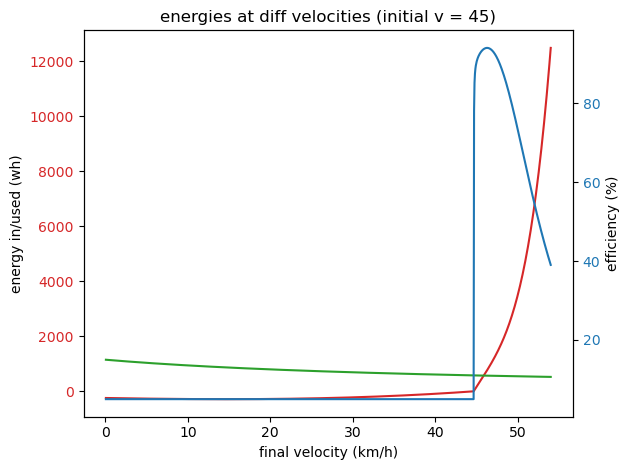

In [76]:
def graph_energy_used_at(route: Route, velocities: list[float], current_time:datetime.datetime):
    x = np.linspace(0, 15, 1000)
    x = x[(x!=0)]
    start_i = 100
    c1 = route.checkpoints[start_i]
    c2 = route.checkpoints[start_i+1]
    distance = c2.distance - c1.distance
    old_speed = velocities[start_i] / 3.6
    print(distance)
    p = []
    p_in=[]
    eff = []
    for i in x:
        if i!= 0:
            a = (i**2 - old_speed**2)/(2*distance)
            t = (i - old_speed) / a
            print(t)
            e, ep, tp = energy_used_between_points(c1, c2, old_speed, i, t)
            ei = energy_captured_between_points(c1, current_time, t) * 3600 
            p.append(ep)
            eff.append(100*(tp / ep if ep > 0 else ep / tp))
            p_in.append(ei)

    fig, ax1 = plt.subplots()
    ax1.plot(x*3.6, p, color='tab:red')
    ax1.plot(x*3.6, p_in, color='tab:green')
    ax1.set_xlabel('final velocity (km/h)')
    ax1.set_ylabel('energy in/used (Wh/Ws)')
    ax1.set_title(f'energies at diff velocities (initial v = {round(old_speed*3.6)})')
    ax1.tick_params(axis='y', labelcolor='tab:red')
    ax2 = ax1.twinx()
    ax2.set_ylabel('efficiency (%)')
    ax2.plot(x*3.6, eff, color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')
    
    fig.tight_layout()
    plt.show()

graph_energy_used_at(route, velocities, loc_dt)

In [35]:
e1, power_outs = energy_used_along_route(route, velocities)
print("energy used (wh): ", e1)
e2, power_ins = energy_captured_along_route(utc_dt, velocities, route)
print("energy captured (wh): ", e2)
print(max(power_outs), min(power_outs), max(power_ins), min(power_ins))
print(len(route.checkpoints), len(power_ins), len(power_outs), len(velocities))

energy used (wh):  3188.028887514375
energy captured (wh):  1295.8866276824815
9809.768297399582 -12731.037067380652 607.7660111185367 0
2574 2574 2574 2574


In [36]:
import folium
import branca.colormap
import pandas as pd
def route_to_list(route: Route):
    coords: list[tuple[float, float]] = [] 
    for checkpoint in route.checkpoints:
        coords.append((checkpoint.lat, checkpoint.lon))
    return coords

def create_map(route: Route, values: list, diverging = True):
    coords = route_to_list(route)
    m = folium.Map()
    if diverging:
        colors: list = branca.colormap.linear.RdYlGn_04.colors
        colors.reverse()
        colormap = branca.colormap.LinearColormap(colors=colors, vmin=min(values), vmax=max(values))
    else:
        colormap = branca.colormap.linear.YlGnBu_07.scale(min(values), max(values)).to_step(7)
    tooltip = [f"{str(v)} | Value: {round(values[i])}" for (i,v) in enumerate(route.checkpoints)]
    for i in range(len(coords)-1):
        rgba = colormap.rgba_floats_tuple(values[i])
        rgba_scaled = (round(i*255) for i in rgba[0:3])
        # print('#{:02x}{:02x}{:02x}'.format(*rgba_scaled))
        folium.PolyLine(locations=[coords[i], coords[i+1]], tooltip=tooltip[i], weight=10, color='#{:02x}{:02x}{:02x}'.format(*rgba_scaled)).add_to(m)
    # folium.ColorLine(positions=coords, colormap=colormap, weight=5, colors=power_list).add_to(m)
    # for i,p in zip_longest(power_list, coords, fillvalue=np.mean(power_list)):
    #     folium.Marker(p, tooltip = i).add_to(m)
    df = pd.DataFrame(coords).rename(columns={0: 'lat', 1: 'lon'})
    sw = df[['lat', 'lon']].min().values.tolist()
    ne = df[['lat', 'lon']].max().values.tolist()
    m.fit_bounds([sw, ne])
    m.add_child(colormap)
    return m
# m1 = create_map(route, powers_in)
m = create_map(route, velocities, False)
m